# Stock Price Prediction

Aim: Create a LSTM model to predict the "Close" stock price of Apple Inc using past 60 days data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM
import math
import pandas_datareader as web
plt.style.use('fivethirtyeight')

Using TensorFlow backend.


# Import Data
- Get the stock quote using Yahoo Finance API
- Data from 2012 to Dec 17,2019

In [2]:
df=  web.DataReader('AAPL',data_source='yahoo', start='2012-01-01', end='2019-12-17')
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,14.732142,14.607142,14.621428,14.686786,302220800.0,12.669562
2012-01-04,14.810000,14.617143,14.642858,14.765715,260022000.0,12.737655
2012-01-05,14.948215,14.738214,14.819643,14.929643,271269600.0,12.879071
2012-01-06,15.098214,14.972143,14.991786,15.085714,318292800.0,13.013705
2012-01-09,15.276786,15.048214,15.196428,15.061786,394024400.0,12.993064


- Open: Starting price 
- Close: Final price
- High: Highest price that day
- Low: Highest price that day

In [3]:
df.shape

(2003, 6)

# Visual Insight
Trend of closing price per the years

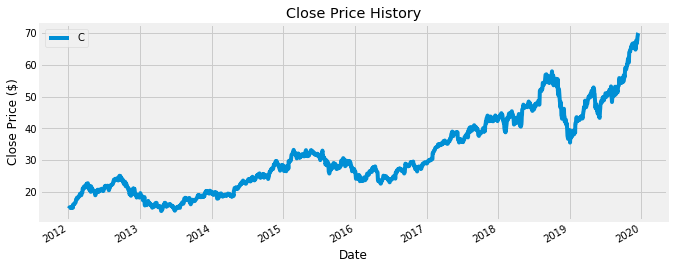

In [4]:
df['Close'].plot(figsize=(10,4), legend=True)
plt.legend('Close Price @Apple')
plt.title('Close Price History')
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.show()

Let's predict the close price. Hence, datafaming the Close column

In [5]:
df = df[['Close']]
df_array = df.values

In [6]:
#train_data = df[:'2015'].values
#test_data = df['2016':'2017'].values
train_data_len = math.ceil(len(df)*0.8)

In [7]:
train_data_len

1603

In [8]:
#train_data = df_array[0:train_data_len , :]

## Scale the train data

In [9]:
sc = MinMaxScaler()
#train_scaled = sc.fit_transform(train_data)
scaled = sc.fit_transform(df)

In [10]:
scaled

array([[0.01316509],
       [0.01457064],
       [0.01748985],
       ...,
       [0.97658263],
       [0.99755134],
       [1.        ]])

# Prepare Training Data with the past 60 days
- xtrain: 1st indexed array has index values from 0-59, 2nd has 1-60 and so on..
- ytrain: 1st value would be 61st value(prediction of next day) and so one

In [11]:
xtrain, ytrain = [], []
for i in range(60, len(scaled)):
    #contain 60 values from pos 1 - 59. 
    xtrain.append(scaled[i-60:i])
    #at poition 60
    ytrain.append(scaled[i])

In [12]:
scaled[0:61][-1]

array([0.13949272])

In [13]:
scaled[60]

array([0.13949272])

In [14]:
xtrain[0][-1]

array([0.14442805])

In [15]:
xtrain[1][0]

array([0.01457064])

In [16]:
ytrain[0]

array([0.13949272])

Convert list into arrays to be usedin LSTM model

In [17]:
xtrain, ytrain = np.array(xtrain), np.array(ytrain)

LSTM data should be in specific shape as (samples(rows), step(cols), features)

In [18]:
xtrain.shape

(1943, 60, 1)

# Model Building

In [19]:
regressor_model = Sequential()
# Adding the first LSTM layer
regressor_model.add(LSTM(units=50, return_sequences=True, input_shape = (xtrain.shape[1],1)))
# Adding a second LSTM layer
regressor_model.add(LSTM(units=50, return_sequences=True))
regressor_model.add(LSTM(units=50, return_sequences=False))

regressor_model.add(Dense(units=1))

In [20]:
regressor_model.compile(optimizer='adam', metrics=['accuracy'], loss='mean_squared_error')

In [21]:
regressor_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [22]:
regressor_model.fit(xtrain, ytrain, epochs=15, batch_size=32)

Epoch 1/15
1943/1943 [==============================] - 11s 5ms/step - loss: 0.0066 - accuracy: 0.0010
Epoch 2/15
1943/1943 [==============================] - 9s 5ms/step - loss: 8.5367e-04 - accuracy: 0.0010
Epoch 3/15
1943/1943 [==============================] - 9s 5ms/step - loss: 7.7478e-04 - accuracy: 0.0010
Epoch 4/15
1943/1943 [==============================] - 9s 5ms/step - loss: 6.9020e-04 - accuracy: 0.0010
Epoch 5/15
1943/1943 [==============================] - 9s 5ms/step - loss: 7.3161e-04 - accuracy: 0.0010
Epoch 6/15
1943/1943 [==============================] - 9s 5ms/step - loss: 6.0101e-04 - accuracy: 0.0010
Epoch 7/15
1943/1943 [==============================] - 8s 4ms/step - loss: 4.9978e-04 - accuracy: 0.0010
Epoch 8/15
1943/1943 [==============================] - 8s 4ms/step - loss: 4.9800e-04 - accuracy: 0.0010
Epoch 9/15
1943/1943 [==============================] - 8s 4ms/step - loss: 4.4856e-04 - accuracy: 0.0010
Epoch 10/15
1943/1943 [==========================

# Prepare Test Data
Take the index direct after the train_data index. Since 60 days data is considered, hence, 1st index of xtest should be 60 past days and ytest be its 61st value

In [23]:
train_data_len

1603

In [24]:
test_data = scaled[train_data_len - 60:, :]
xtest = []
ytest = df_array[train_data_len: , :]
for i in range(60, len(test_data)):
    xtest.append(test_data[i-60:i, 0])

In [26]:
#xtest = sc.transform(xtest)

In [25]:
xtest = np.array(xtest)

In [26]:
xtest.shape

(400, 60)

LSTM data should be in specific shape as (samples(rows), step(cols), features)

In [27]:
xtest = np.reshape(xtest, (xtest.shape[0], xtest.shape[1],1))

In [28]:
xtest.shape

(400, 60, 1)

# Model Predictions

In [29]:
predictions = regressor_model.predict(xtest)

In [30]:
predictions = sc.inverse_transform(predictions)

In [31]:
predictions

array([[47.506256],
       [47.564724],
       [47.45962 ],
       [47.261734],
       [47.013092],
       [46.77073 ],
       [46.558388],
       [46.39495 ],
       [46.27172 ],
       [46.176914],
       [46.09482 ],
       [46.07839 ],
       [46.155533],
       [46.336216],
       [46.602734],
       [46.90717 ],
       [47.178806],
       [47.37871 ],
       [47.51532 ],
       [47.569008],
       [47.551716],
       [47.449997],
       [47.283863],
       [47.03176 ],
       [46.736515],
       [46.42007 ],
       [46.10525 ],
       [45.773235],
       [45.480953],
       [45.249092],
       [45.108707],
       [45.052517],
       [45.09927 ],
       [45.176987],
       [45.279472],
       [45.434536],
       [45.673733],
       [45.97224 ],
       [46.252758],
       [46.531796],
       [46.80013 ],
       [47.034416],
       [47.229485],
       [47.36108 ],
       [47.45196 ],
       [47.502487],
       [47.520763],
       [47.537224],
       [47.58957 ],
       [47.666378],


# Model Evaluation

In [32]:
rmse = np.sqrt(np.mean((predictions - ytest)**2))
rmse

1.5780462487813112

In [33]:
train = df[:train_data_len]
valid = df[train_data_len:]
valid['Predictions'] = predictions

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


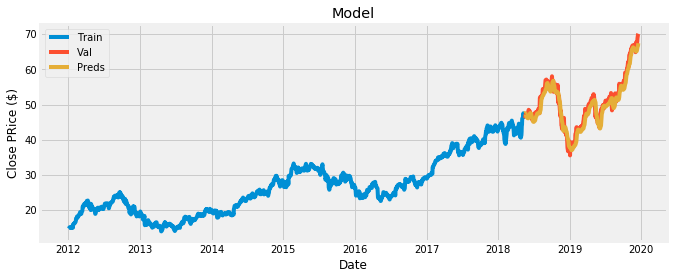

In [34]:
plt.figure(figsize=(10,4))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close PRice ($)')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Preds'])
plt.show()

In [35]:
valid

,Close,Predictions
Date,,
2018-05-17,46.747501,47.506256
2018-05-18,46.577499,47.564724
2018-05-21,46.907501,47.459621
2018-05-22,46.790001,47.261734
2018-05-23,47.090000,47.013092
2018-05-24,47.037498,46.770729
2018-05-25,47.145000,46.558388
2018-05-29,46.974998,46.394951
2018-05-30,46.875000,46.271721


# Predict closing proice for dec 27, 2019

In [64]:
df=  web.DataReader('AAPL',data_source='yahoo', start='2012-01-01', end='2019-12-26')

In [65]:
new_df = df[['Close']]

In [66]:
# get last 60 days
last_60_days = new_df[-60:].values

#scaling
last_60_days_scaled = sc.transform(last_60_days)

In [67]:
xtest = []
#append past 60 days
xtest.append(last_60_days_scaled)
xtest = np.array(xtest)

In [68]:
xtest.shape

(1, 60, 1)

In [69]:
predicted_test = regressor_model.predict(xtest)
predicted_test = sc.inverse_transform(predicted_test)

In [70]:
predicted_test

array([[71.17255]], dtype=float32)

In [71]:
df = web.DataReader('AAPL', data_source='yahoo', start='2019-12-27', end='2019-12-27')

df['Close']

Date
2019-12-26    72.477501
2019-12-27    72.449997
Name: Close, dtype: float64

In [72]:
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-12-26,72.495003,71.175003,71.205002,72.477501,93121200,71.856941
2019-12-27,73.492500,72.029999,72.779999,72.449997,146266000,71.829674


As we can see that actual Close price for 27th Dec, 2019 "72.449997" is closer to "71.17255"

# END